In [1]:
import pandas as pd,numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py

In [ ]:
import sys
# sys.setdefaultencoding() does not exist, here!
reload(sys)  # Reload does the trick!
sys.setdefaultencoding('utf-8')

In [2]:
df = pd.read_excel('CB_Nov16_Enrich_02Websites - ScoredFinal - 21Dec16.xlsx',sheetname=1)
df.shape

(441, 24)

In [3]:
df = df.dropna(subset=['Subscription/ Online Payment'])
df.shape

(253, 24)

In [4]:
df = df[~df['Remarks'].isin(['Chargebee Test/Training?','NOT FOUND'])]
df.shape

(208, 24)

In [5]:
df.index = range(df.shape[0])

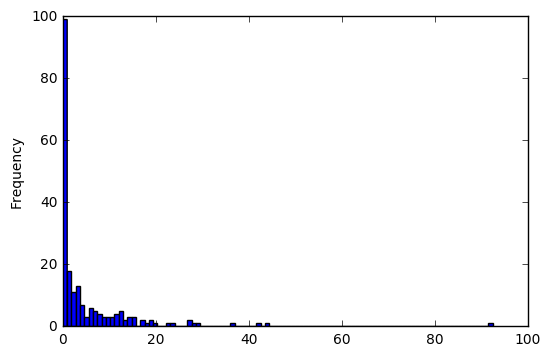

In [6]:
plt.figure()
df.ix[df['Pricing_score']>=0,'Pricing_score'].plot.hist(bins=100)
# plt.hist(list(df['Pricing_score']))
plt.show()

In [7]:
df.ix[df['Pricing_score']>=0,'Pricing_score'].quantile(np.arange(0,1,0.2))

0.0    0.00
0.2    0.00
0.4    0.00
0.6    2.24
0.8    8.24
Name: Pricing_score, dtype: float64

In [8]:
df['pricing_score_range'] = 'no_score' #score = -1000 or -9999
df.ix[df['Pricing_score']==0,'pricing_score_range'] = '0'
df.ix[(df['Pricing_score']>0)&(df['Pricing_score']<=2.24),'pricing_score_range'] = '0-2.24'
df.ix[(df['Pricing_score']>2.24)&(df['Pricing_score']<=8.24),'pricing_score_range'] = '2.24-8.24'
df.ix[(df['Pricing_score']>8.24),'pricing_score_range'] = '>8.24'

In [9]:
df['pricing_score_range'].value_counts()

0            91
>8.24        42
2.24-8.24    41
0-2.24       34
Name: pricing_score_range, dtype: int64

In [10]:
df['payment_gateway_exists'] = True
df.ix[df['Existing Payment Gateway'].isnull(),'payment_gateway_exists'] = False
df['payment_gateway_exists'].value_counts()

True     154
False     54
Name: payment_gateway_exists, dtype: int64

In [11]:
df_to_model = df[['pricing_score_range','PaymentType','payment_gateway_exists','demo_option','pricing_page',
                  'login_option']]
df_to_model.columns = ['pricing_score_range','PaymentType','payment_gateway_exists','demo_option','pricing_page',
                  'login_option']
df_to_model.shape

(208, 6)

In [12]:
df_to_model_numeric = pd.get_dummies(df_to_model)
df_to_model_numeric.columns = [ 'payment_gateway_exists',                   'demo_option',
                        'pricing_page',                  'login_option',
               'pricing_score_range_0',    'pricing_score_range_0-2.24',
       'pricing_score_range_2.24-8.24',    'pricing_score_range_>8.24',
            'PaymentType_not_charging',           'PaymentType_offline',
          'PaymentType_online_offline']
df_to_model_numeric.head()

,payment_gateway_exists,demo_option,pricing_page,login_option,pricing_score_range_0,pricing_score_range_0-2.24,pricing_score_range_2.24-8.24,pricing_score_range_>8.24,PaymentType_not_charging,PaymentType_offline,PaymentType_online_offline
0,True,False,True,False,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,True,False,True,True,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,True,False,True,True,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,True,True,True,True,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,False,False,False,True,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [13]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.metrics import classification_report
from sklearn import tree

In [14]:
mnb = MultinomialNB(fit_prior=False)
mnb.fit(df_to_model_numeric,df['Subscription/ Online Payment']=='1 - Subscr Pricing')

print classification_report(df['Subscription/ Online Payment']=='1 - Subscr Pricing',mnb.predict(df_to_model_numeric))

             precision    recall  f1-score   support

      False       0.93      0.70      0.80       142
       True       0.58      0.88      0.70        66

avg / total       0.82      0.76      0.77       208



In [15]:
clf = tree.DecisionTreeClassifier(class_weight='balanced',min_weight_fraction_leaf=0.05,max_depth=4)
clf.fit(df_to_model_numeric,df['Subscription/ Online Payment']=='1 - Subscr Pricing')
print classification_report(df['Subscription/ Online Payment']=='1 - Subscr Pricing',clf.predict(df_to_model_numeric))

             precision    recall  f1-score   support

      False       0.96      0.79      0.86       142
       True       0.67      0.92      0.78        66

avg / total       0.87      0.83      0.84       208



In [16]:
from IPython.display import Image  
import pydotplus
from IPython.display import Image  

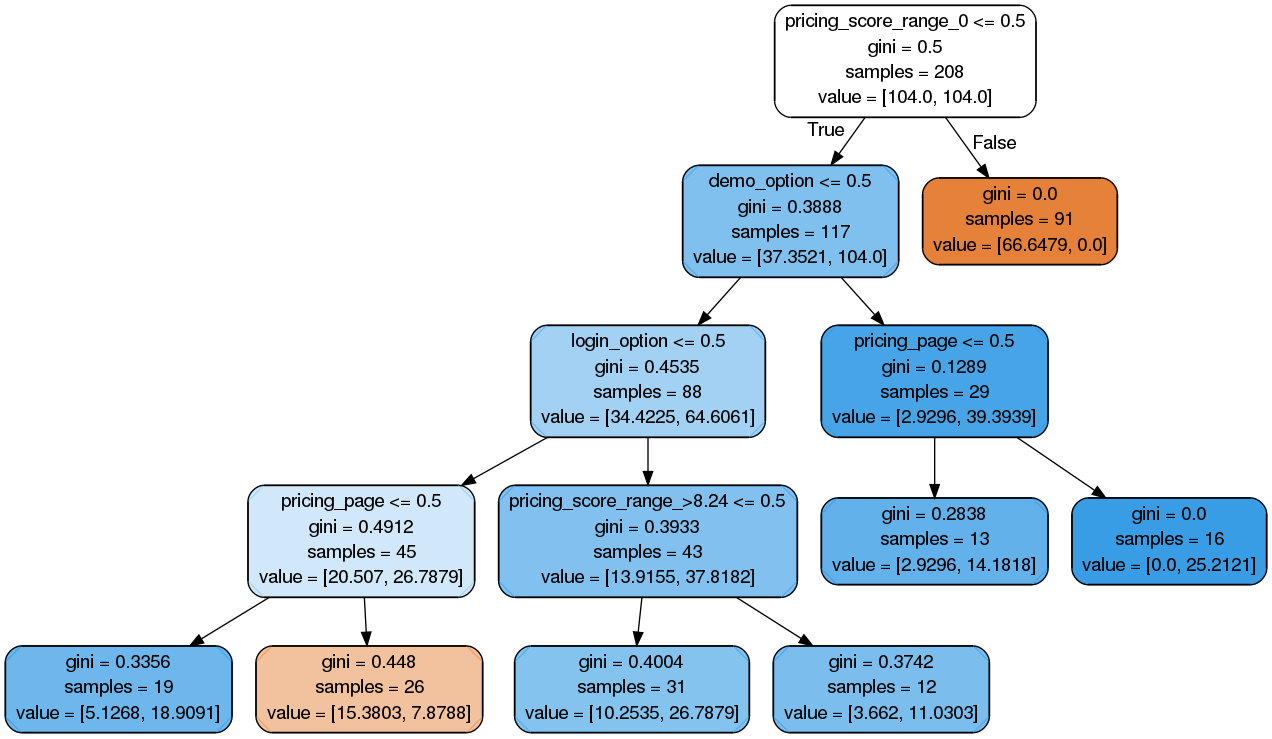

In [17]:
dot_data = tree.export_graphviz(clf,out_file=None,feature_names=df_to_model_numeric.columns,filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data) 
# graph.write_png("tree_model_balanced.png") 
Image(graph.create_png())  

### adding more data

In [18]:
df_new = pd.read_csv('SAAS_Classified_crawler_input.csv')
df_new.shape

(533, 6)

In [19]:
df_new_vars = pd.read_csv('SAAS_Classified_crawler_output.csv',sep=None)
df_new_vars.shape

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.



(525, 10)

In [20]:
df_new.head()

,id,company_name,website,SaaS type,Online Payments Classifications,company_linkedin_url
0,1,Atlanta Tech Village,atlantatechvillage.com,Community,0,https://www.linkedin.com/company/atlanta-tech-...
1,2,FounderDating,founderdating.com,Community,0,https://www.linkedin.com/company/founderdating
2,3,"SWBCF | Student Women in Business, Consulting ...",swbcf.org,Community,0,https://www.linkedin.com/company/swbcf-student...
3,4,Trend Tribe,www.trend-tribe.com,Community,0,https://www.linkedin.com/company/trend-tribe
4,5,KPMG Australia,www.kpmg.com.au,Consulting,0,https://www.linkedin.com/company/kpmg-australia


In [21]:
df_new_vars.head()

,company_linkedin_url,demo_present,emails,id,login_present,match_texts_test,pricing_present,score,urls,website
0,https://www.linkedin.com/company/saasgenius,False,[],95,True,"[((u'Pricing',), u'The Best Personalization an...",True,105.3,[u'https://www.linkedin.com/company/saasgenius...,http://www.saasgenius.com
1,https://www.linkedin.com/company/woopra-inc-,True,[u'mailto:legal@woopra.com'],457,True,"[((u'SUBSCRIPTION',), u'YOU ALSO MAY CHANGE YO...",True,95.2,[u'http://www.linkedin.com/company/woopra-inc-...,http://www.woopra.com
2,https://www.linkedin.com/company/lob,False,[],352,True,"[((u'Demo',), u'create (\nto_address\n=\n{\n\'...",True,86.1,"[u'https://www.linkedin.com/company/lob', u'ht...",http://www.lob.com
3,https://www.linkedin.com/company/subbly,True,[u'mailto:support@subbly.co'],76,True,"[((u'Subscription',), u'Need an Easy Way to St...",True,80.3,"[u'http://www.facebook.com/subblyco', u'http:/...",http://www.subbly.co
4,https://www.linkedin.com/company/takipi,True,[u'mailto:hello@overops.com'],432,True,"[((u'pricing',), u'Please contact us for micro...",True,64.7,"[u'http://www.twitter.com/overopshq', u'https:...",http://www.takipi.com


In [22]:
df_new_full = pd.merge(df_new,df_new_vars,on='id')
df_new_full.shape

(525, 15)

In [23]:
df_new_full['pricing_score_range'] = 'no_score' #score = -1000 or -9999
df_new_full.ix[df_new_full['score']==0,'pricing_score_range'] = '0'
df_new_full.ix[(df_new_full['score']>0)&(df_new_full['score']<=2.24),'pricing_score_range'] = '0-2.24'
df_new_full.ix[(df_new_full['score']>2.24)&(df_new_full['score']<=8.24),'pricing_score_range'] = '2.24-8.24'
df_new_full.ix[(df_new_full['score']>8.24),'pricing_score_range'] = '>8.24'

df_new_full_vars = df_new_full[['score','demo_present','login_present','pricing_present']]
df_new_full_vars.columns = ['Pricing_score','demo_option','pricing_page','login_option']
df_to_model = df[['Pricing_score','PaymentType','payment_gateway_exists','demo_option','pricing_page',
                  'login_option']]
df_old_vars = df_to_model[['Pricing_score','demo_option','pricing_page','login_option']]

In [24]:
new_data = pd.concat([df_old_vars,df_new_full_vars],ignore_index=True)
new_data['login_option'] = new_data['login_option'].fillna(False)
new_data['Pricing_score'] = new_data['Pricing_score'].fillna(0)
new_data.head()

,Pricing_score,demo_option,pricing_page,login_option
0,0.0,False,True,False
1,0.0,False,True,True
2,3.6,False,True,True
3,92.4,True,True,True
4,0.0,False,False,True


In [25]:
#setting dv
dv_old = df['Subscription/ Online Payment']=='1 - Subscr Pricing'
# dv_new = df_new_full['SaaS type'].isin(['eCom subscr','SaaS','Services subscr','Services  subscr'])
dv_new = df_new_full['SaaS type'].isin(['SaaS'])
new_data_dv = pd.concat([dv_old,dv_new],ignore_index=True)
new_data_dv.shape

(733,)

In [26]:
new_data_dv.value_counts()

False    458
True     275
dtype: int64

In [27]:
new_data_vars = pd.get_dummies(new_data,drop_first=False)
new_data_vars.head()

,Pricing_score,demo_option,pricing_page,login_option
0,0.0,False,True,False
1,0.0,False,True,True
2,3.6,False,True,True
3,92.4,True,True,True
4,0.0,False,False,True


In [49]:
clf = tree.DecisionTreeClassifier(min_weight_fraction_leaf=0.01,class_weight='balanced',max_depth=4,min_samples_leaf=20)
clf.fit(new_data_vars,new_data_dv)
print classification_report(new_data_dv,clf.predict(new_data_vars))

             precision    recall  f1-score   support

      False       0.78      0.76      0.77       458
       True       0.62      0.65      0.63       275

avg / total       0.72      0.72      0.72       733



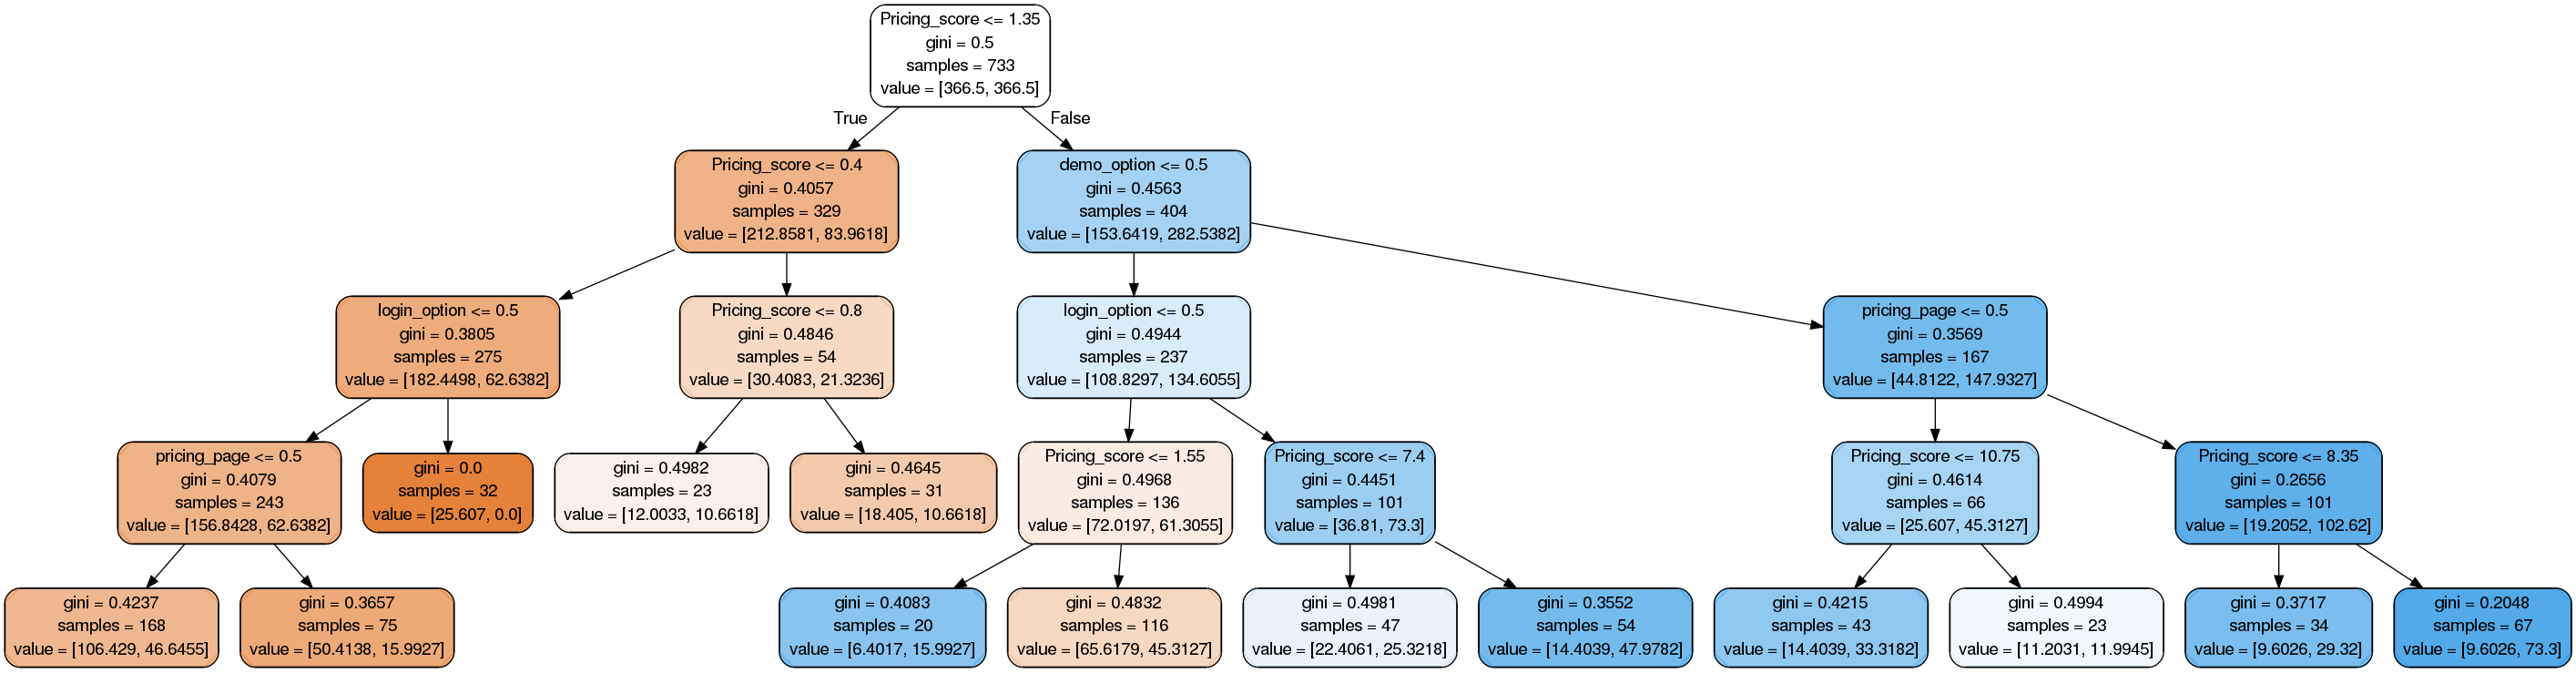

In [50]:
# import sys
# # sys.setdefaultencoding() does not exist, here!
# reload(sys)  # Reload does the trick!
# sys.setdefaultencoding('UTF8')
dot_data = tree.export_graphviz(clf,out_file=None,feature_names=new_data_vars.columns,filled=True, rounded=True)  

graph = pydotplus.graph_from_dot_data(dot_data.encode('ascii','ignore')) 
graph.write_png("tree_model_additional_data_balanced.png") 
Image(graph.create_png())  

In [51]:
## use score directly in old one
df_to_model = df[['Pricing_score','PaymentType','payment_gateway_exists','demo_option','pricing_page',
                  'login_option']]
df_to_model.columns = ['Pricing_score','PaymentType','payment_gateway_exists','demo_option','pricing_page',
                  'login_option']
df_to_model.shape

(208, 6)

In [52]:
df_to_model_numeric = pd.get_dummies(df_to_model)
df_to_model_numeric.head()

,Pricing_score,payment_gateway_exists,demo_option,pricing_page,login_option,PaymentType_not_charging,PaymentType_offline,PaymentType_online_offline
0,0.0,True,False,True,False,0.0,0.0,1.0
1,0.0,True,False,True,True,0.0,0.0,1.0
2,3.6,True,False,True,True,0.0,0.0,1.0
3,92.4,True,True,True,True,0.0,0.0,1.0
4,0.0,False,False,False,True,0.0,1.0,0.0


In [54]:
clf = tree.DecisionTreeClassifier(class_weight='balanced',min_weight_fraction_leaf=0.05,max_depth=5)
clf.fit(df_to_model_numeric,df['Subscription/ Online Payment']=='1 - Subscr Pricing')
print classification_report(df['Subscription/ Online Payment']=='1 - Subscr Pricing',clf.predict(df_to_model_numeric))

             precision    recall  f1-score   support

      False       0.99      0.78      0.87       142
       True       0.68      0.98      0.80        66

avg / total       0.89      0.85      0.85       208



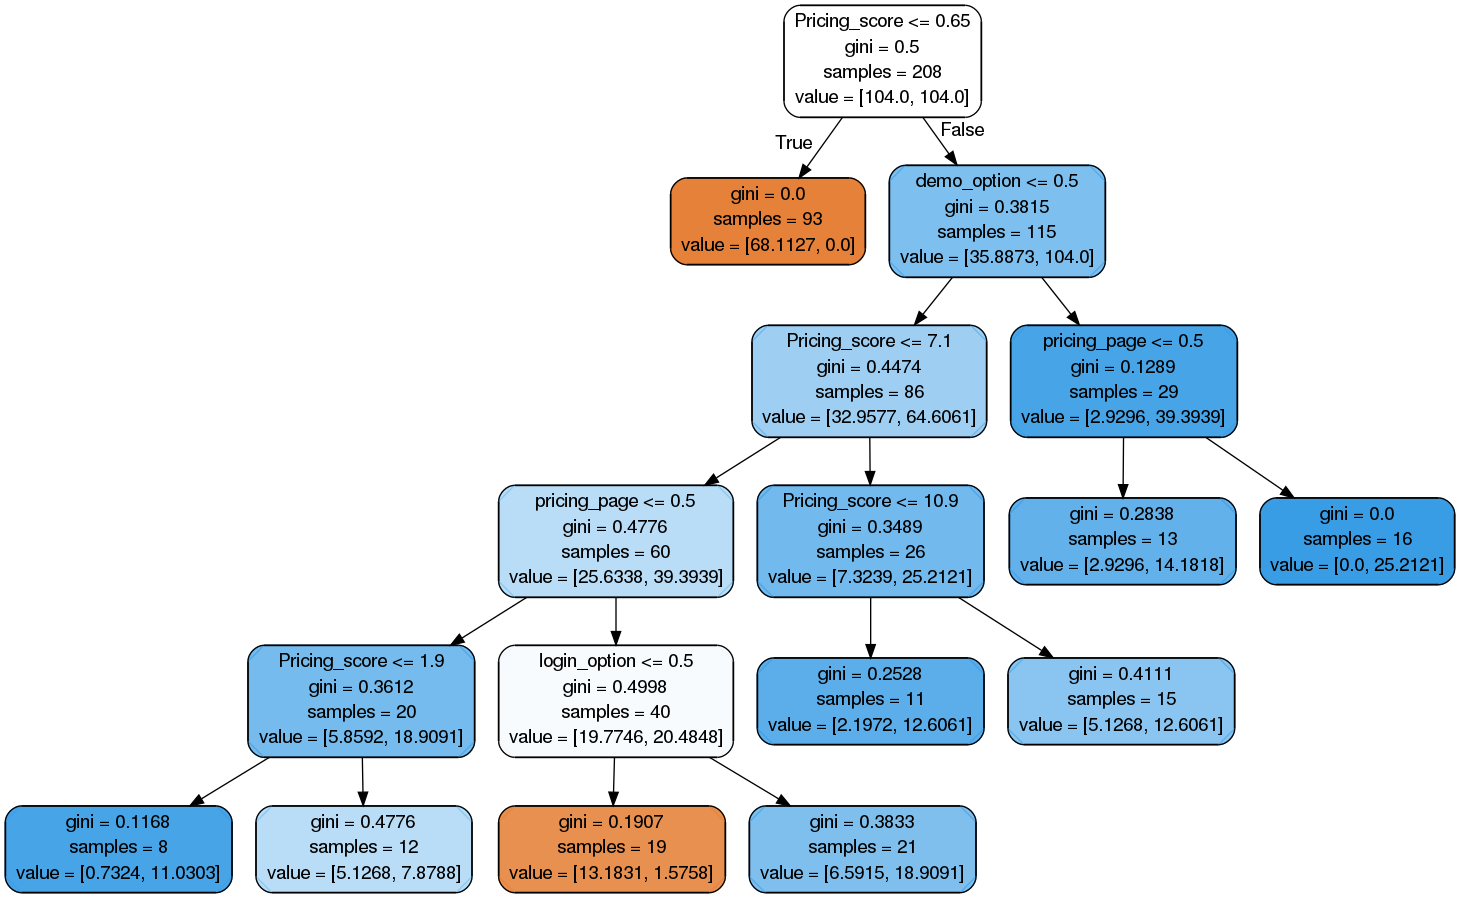

In [55]:
dot_data = tree.export_graphviz(clf,out_file=None,feature_names=df_to_model_numeric.columns,filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data) 
# graph.write_png("tree_model_balanced.png") 
Image(graph.create_png())  